In [1]:
import numpy as np
from matplotlib import pyplot as plt

from warper import simulate_2d_only_memory, simulate_2d_only_memory_anharmonic_1

from multiprocessing import Pool

import os, pickle
from tqdm.notebook import tqdm

import pandas as pd

In [2]:
%matplotlib qt

In [3]:
pool = Pool(4)

In [4]:
def get_RSH(A,B,g0,b,ka):
    o0 = np.sqrt(-A)
    mu = ka
    S = 1/g0/2/ka**2*(ka**2+o0**2+g0*ka+b**2)
    R = 1/g0/2/o0**2/ka**2 * (o0**2+ka**2)
    H = - 1/2/g0/ka**2*b
    return R,S,H, 2*(R*S+H**2)

def mean_with_err(arr, axis):
    return arr.mean(axis=axis), arr.std(axis=axis)/np.sqrt(arr.shape[axis])

In [5]:
# params - A,B,g0,b,ka

params = [
#     (-1,0,1,0,1),
#     (-1,0,1,1,1),
#     (-1,0,1,2,1),
#     (-1,0,1,3,1),
    
#     (-1,0.5,1,0,1),
#     (-1,0.5,1,1,1),
#     (-1,0.5,1,2,1),
#     (-1,0.5,1,3,1),
    
#     (3,0.4,1,0,1),
#     (3,0.4,1,1,1),
#     (3,0.4,1,2,1),
#     (3,0.4,1,3,1),

]

bs =  (0,1,2,3,4,5,6,8,10)#,12,14,16,18,20,22,24,26,28,30)
params += [(-10,0,1,b,1) for b in bs]
params += [(3,0.4,1,b,1) for b in bs]
params += [(2,0.14,1,b,1) for b in bs]

df = pd.DataFrame(params, columns=["A","B","g0","b","ka"])

In [6]:
def f(row):
    return pd.Series(get_RSH(row.A, row.B, row.g0, row.b, row.ka),index=("R","S","H","varL"))
df = pd.concat([df, df.apply(f, axis=1)], axis=1, sort=False)

<ipython-input-4-fd8d9f319383>:2: RuntimeWarning: invalid value encountered in sqrt
  o0 = np.sqrt(-A)


In [7]:
df

,A,B,g0,b,ka,R,S,H,varL
0,-10,0.00,1,0,1,0.55,6.0,-0.0,6.60
1,-10,0.00,1,1,1,0.55,6.5,-0.5,7.65
2,-10,0.00,1,2,1,0.55,8.0,-1.0,10.80
3,-10,0.00,1,3,1,0.55,10.5,-1.5,16.05
4,-10,0.00,1,4,1,0.55,14.0,-2.0,23.40
5,-10,0.00,1,5,1,0.55,18.5,-2.5,32.85
6,-10,0.00,1,6,1,0.55,24.0,-3.0,44.40
7,-10,0.00,1,8,1,0.55,38.0,-4.0,73.80
8,-10,0.00,1,10,1,0.55,56.0,-5.0,111.60
9,3,0.40,1,0,1,NaN,NaN,-0.0,NaN


In [8]:
N=5000000
warmup=0
dt=0.001
samples=200
skip=500
runs=4
time = np.linspace(0,N//skip *dt, N//skip)

dump_to_disk = False

In [9]:
results = []
for row in tqdm(df.itertuples(), total=len(df)):
#     if row.Index <40:
#         continue
    kwargs = dict(x0=np.zeros(samples),y0=np.zeros(samples),
                  vx0=np.zeros(samples),vy0=np.zeros(samples),
        N=N, samples=samples,
        dt=dt, warmup=warmup, skip=skip,
        A=row.A,B=row.B,gamma0=row.g0,b=row.b, kappa=row.ka)
    res = simulate_2d_only_memory_anharmonic_1(pool,runs,**kwargs)
    if dump_to_disk:
        np.save(f"results/{row.Index}", res)
    else:
        results.append(res[:4])

In [10]:
results = np.array(results)

### Load dumped data

In [26]:
import os
n_files = len(os.listdir("results"))

In [30]:
np.load("results/1.npy").shape

(6, 800, 10000)

In [31]:
results = np.zeros((n_files, 4, 800, 5000))

In [38]:
for i in tqdm(range(n_files)):
    results[i] = np.load(f"results/{i}.npy")[:4,:,-5000:]

In [11]:
results[:,:,:,:].shape

(27, 4, 800, 10000)

### Start Analisys

In [12]:
cov = np.einsum("iakj,ibkj->ijab", results[:,:4,:,:],results[:,:4,:,:],optimize=True)/(results.shape[2]-1)

In [13]:
cov.shape

(27, 10000, 4, 4)

In [14]:
plt.plot(cov.transpose(1,0,2,3).reshape(-1,cov.shape[0]*16)[::], alpha=0.2);
# plt.plot(cov[5,:,1,2]);

In [15]:
stationari_treshold = 2000

In [16]:
results.shape

(27, 4, 800, 10000)

In [17]:
Rx,Ry, Sx, Sy = results[...,stationari_treshold:].var(axis=2).transpose(1,0,2)
Lx = results[:,0] * results[:,3]
Ly = results[:,1] * results[:,2]

Hx = Lx.mean(axis=1)
Hy = Ly.mean(axis=1)

In [18]:
df["Rx"], df["Rx_err"]= mean_with_err(Rx,axis=-1)
df["Ry"], df["Ry_err"]= mean_with_err(Ry,axis=-1)
df["Sx"], df["Sx_err"]= mean_with_err(Sx,axis=-1)
df["Sy"], df["Sy_err"]= mean_with_err(Sy,axis=-1)
df["Hx"], df["Hx_err"]= mean_with_err(Hx,axis=-1)
df["Hy"], df["Hy_err"]= mean_with_err(Hy,axis=-1)

# df["Rx"], df["Rx_err"]= mean_with_err(Rx,axis=-1)


In [19]:
df[sorted(df.columns)].round(4)

,A,B,H,Hx,Hx_err,Hy,Hy_err,R,Rx,Rx_err,...,Ry_err,S,Sx,Sx_err,Sy,Sy_err,b,g0,ka,varL
0,-10,0.00,-0.0,-0.0037,0.0006,0.0037,0.0006,0.55,0.5476,0.0003,...,0.0003,6.0,5.9745,0.0033,6.0294,0.0035,0,1,1,6.60
1,-10,0.00,-0.5,-0.5007,0.0007,0.5010,0.0007,0.55,0.5489,0.0003,...,0.0003,6.5,6.4908,0.0036,6.4948,0.0036,1,1,1,7.65
2,-10,0.00,-1.0,-0.9964,0.0009,0.9965,0.0009,0.55,0.5483,0.0003,...,0.0003,8.0,7.9771,0.0045,7.9754,0.0045,2,1,1,10.80
3,-10,0.00,-1.5,-1.4930,0.0012,1.4930,0.0012,0.55,0.5488,0.0003,...,0.0003,10.5,10.4878,0.0057,10.4879,0.0057,3,1,1,16.05
4,-10,0.00,-2.0,-1.9892,0.0016,1.9905,0.0016,0.55,0.5486,0.0003,...,0.0003,14.0,13.9591,0.0076,13.9531,0.0076,4,1,1,23.40
5,-10,0.00,-2.5,-2.4657,0.0021,2.4666,0.0021,0.55,0.5479,0.0003,...,0.0003,18.5,18.4231,0.0111,18.4108,0.0111,5,1,1,32.85
6,-10,0.00,-3.0,-2.9647,0.0025,2.9644,0.0025,0.55,0.5484,0.0003,...,0.0003,24.0,23.9139,0.0138,23.9170,0.0138,6,1,1,44.40
7,-10,0.00,-4.0,-3.9373,0.0035,3.9374,0.0035,0.55,0.5481,0.0003,...,0.0003,38.0,37.8471,0.0215,37.8468,0.0215,8,1,1,73.80
8,-10,0.00,-5.0,-4.9060,0.0047,4.9067,0.0047,0.55,0.5465,0.0003,...,0.0003,56.0,55.5944,0.0306,55.5957,0.0307,10,1,1,111.60
9,3,0.40,-0.0,-0.0005,0.0008,0.0005,0.0008,NaN,3.5110,0.0012,...,0.0012,NaN,1.7331,0.0010,1.7344,0.0010,0,1,1,NaN


In [24]:
gb=df.groupby("B")

plt.figure(figsize=(10,7), dpi=150)
plt.title("H vs b")
plt.xlabel("b");plt.ylabel("H")
plt.plot(gb.get_group(0).b, gb.get_group(0).H, ls=(0, (5, 10)), label="harmonic")
for key in gb.groups:
    gp = gb.get_group(key)
#     plt.plot(gp.b, gp.Hx)
    plt.errorbar(gp.b, gp.Hx, yerr=gp.Hx_err*10, capsize=7, marker="o", ls="none", label=f"A: {gp.A.mean():0.3f} B: {gp.B.mean():0.3f}")
# plt.xlim(-1,5)
# plt.ylim(-4,1)
plt.legend()

In [23]:
gb=df.groupby("B")

plt.figure(figsize=(10,7), dpi=150)
plt.subplot(121)
plt.title("R vs b")
plt.xlabel("b");plt.ylabel("R")
plt.plot(gb.get_group(0).b, gb.get_group(0).R, ls=(0, (5, 10)), label="harmonic")
for key in gb.groups:
    gp = gb.get_group(key)
#     plt.plot(gp.b, gp.Hx)
    plt.errorbar(gp.b, gp.Rx, yerr=gp.Rx_err*10, capsize=7, marker="o", ls="none", label=f"A: {gp.A.mean():0.3f} B: {gp.B.mean():0.3f}")
plt.legend()

plt.subplot(122)
plt.title("S vs b")
plt.xlabel("b");plt.ylabel("S")
plt.plot(gb.get_group(0).b, gb.get_group(0).S, ls=(0, (5, 10)), label="harmonic")
for key in gb.groups:
    gp = gb.get_group(key)
#     plt.plot(gp.b, gp.Hx)
    plt.errorbar(gp.b, gp.Sx, yerr=gp.Sx_err*10, capsize=7, marker="o", ls="none", label=f"A: {gp.A.mean():0.3f} B: {gp.B.mean():0.3f}")
plt.legend()

In [102]:
gb.groups

{0.0: Int64Index([0, 1, 2, 3], dtype='int64'),
 0.5: Int64Index([4, 5, 6, 7], dtype='int64')}

In [98]:
dir(gb)

['A',
 'B',
 'H',
 'Hx',
 'Hx_err',
 'Hy',
 'Hy_err',
 'R',
 'Rx',
 'Rx_err',
 'Ry',
 'Ry_err',
 'S',
 'Sx',
 'Sx_err',
 'Sy',
 'Sy_err',
 '__bytes__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__unicode__',
 '__weakref__',
 '_accessors',
 '_add_numeric_operations',
 '_agg_examples_doc',
 '_agg_see_also_doc',
 '_aggregate',
 '_aggregate_generic',
 '_aggregate_item_by_item',
 '_aggregate_multiple_funcs',
 '_apply_filter',
 '_apply_to_column_groupbys',
 '_apply_whitelist',
 '_assure_grouper',
 '_block_agg_axis',
 '_bool_agg',
 '_builtin_table',
 '_choose_path',
 '_concat_objects',
 '_constructor',
 '_cumcount_array',
 '_cyt

In [14]:
R_sample = results.var(axis=2)[:,0] 
S_sample = results.var(axis=2)[:,2]

In [18]:
L = (results[:,0] * results[:,3] - results[:,1] * results[:,2])
H_sample = L.mean(axis=1)/2

In [20]:
H_sample.shape

(8, 5000)

In [23]:
H_sample[:,-3000:].mean(axis=1)

array([ 1.36738691e-03, -4.97941103e-01, -9.98061171e-01, -1.49994406e+00,
        1.76045506e-03, -4.93537808e-01, -9.87554594e-01, -1.48736006e+00])

In [28]:
np.sqrt(H_sample[:,-3000:].var(axis=1)/3000)

array([0.00046711, 0.00053121, 0.00076802, 0.00109853, 0.00046564,
       0.00054357, 0.00074373, 0.00096304])

In [24]:
H

(-0.0, -0.5, -1.0, -1.5, -0.0, -0.5, -1.0, -1.5)

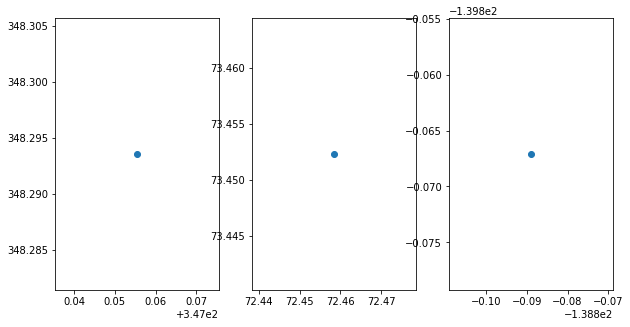

In [16]:
plt.figure(figsize=(10,5))
plt.subplot(131)
plt.scatter(S, S_sample[..., -1])
plt.subplot(132)
plt.scatter(R, R_sample[..., -1])
plt.subplot(133)
plt.scatter(H, H_sample[..., -1])

In [17]:
results.shape

(1, 6, 800, 5000)

In [18]:
L.shape

(1, 800, 5000)

In [33]:
# T = results[:,2,:,:]
T = L/2
hlines = H

In [35]:
T.shape[0]

1

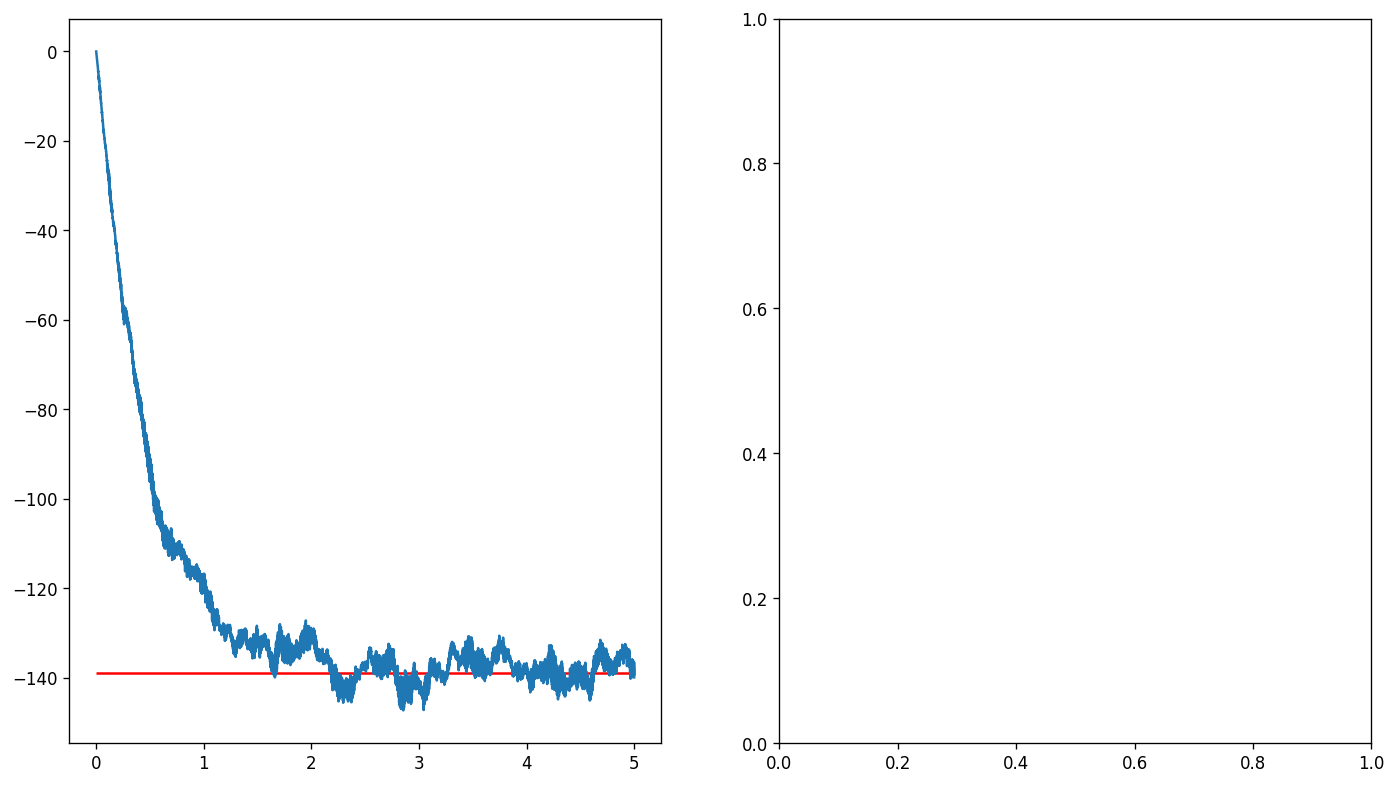

In [36]:
fig, axs = plt.subplots(1+T.shape[0]//2,2,figsize=(14,8),dpi=120)
for ax, xi,h in zip(axs.flatten(),T[:,:,:], hlines):
    ax.plot(time, xi.mean(axis=0))
    ax.hlines(y=h, xmin=0, xmax=max(time), colors="r")
# plt.show()

In [20]:
L.shape

(2, 800, 5000)

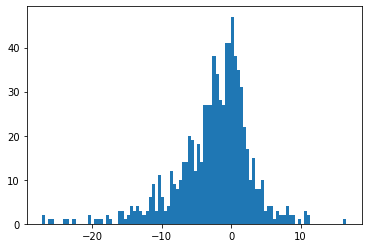

In [21]:
plt.hist(L[0,:,-1], bins=100);

In [22]:
L[1,:,-1].mean()

-275.58011008311655

In [23]:
sorted(L[1,:,-1])[1600]

IndexError: list index out of range

In [ ]:
L.shape

In [ ]:
plt.figure(figsize=(14,8))
plt.plot(L[1,2,3000:])